In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,StandardScaler,OrdinalEncoder,TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,KFold,RandomizedSearchCV
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor,plot_tree
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import optuna
from plotly.io import show

pd.set_option('display.max_columns', None)

In [104]:
df = pd.read_csv('final_df.csv')

In [105]:
x = df.drop('price',axis=1)
y = df['price']
y = np.log1p(y)

In [106]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [107]:
missing_pipe_cat_age = Pipeline([
    ('Missing_Cat', SimpleImputer(strategy='most_frequent')),
    ('Onehot',OneHotEncoder(drop='first',handle_unknown='ignore',sparse_output=False))
    ])

missing_pipe_cat_floor = Pipeline([
    ('Missing_Cat', SimpleImputer(strategy='most_frequent')),
    ('ordinal',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1))
    ])

missing_pipe_num = Pipeline([
    ('Missing_Num', SimpleImputer(strategy='median')),
    ('scaling',StandardScaler())
     ])


Target_preprocessor = ColumnTransformer([
    ('missing_pipe_cat_age',missing_pipe_cat_age,['agePossession']),
    ('missing_pipe_cat_floor',missing_pipe_cat_floor,['floorNum_cat']),
    ('missing_pipe_num',missing_pipe_num,[ 'super_built_up_area','built_up_area', 'carpet_area']),
    ('ordinal',OrdinalEncoder(),['balcony','luxury_cat']),
    ('onehot',OneHotEncoder(drop='first', handle_unknown='ignore'), ['furnishing_type','property_type']),
    # ('target',ce.TargetEncoder(),['sector']),
    ('scaling',StandardScaler(),['bedRoom', 'bathroom', 'study room', 'servant room'])
    ],remainder='passthrough')


model_pipe = Pipeline([
    ('target',ce.TargetEncoder(cols=['sector'])),
    ('TargetEncoder',Target_preprocessor),
    ('model',RandomForestRegressor(random_state=0,n_estimators=1,max_depth=3,n_jobs=-1))
])


cv_score = cross_val_score(model_pipe,x_train,y_train,cv=5,scoring='r2',n_jobs=1)
cv_score.mean()

np.float64(0.6780471532510705)

In [108]:
model_pipe.fit(x_train,y_train)



c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning:


The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).




Pipeline(steps=[('target', TargetEncoder(cols=['sector'])),
                ('TargetEncoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('missing_pipe_cat_age',
                                                  Pipeline(steps=[('Missing_Cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('Onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['agePossession']),
                                                 ('missing_pipe_cat_...
                                                   'built_up_area',
                                                   'carpet_area']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['balcony', 'luxury_cat']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['furnishing_type',
                                                   'property_type']),
                                                 ('scaling', StandardScaler(),
                                                  ['bedRoom', 'bathroom',
                                                   'study room',
                                                   'servant room'])])),
                ('model',
                 RandomForestRegressor(max_depth=3, n_estimators=1, n_jobs=-1,
                                       random_state=0))])

In [109]:
from sklearn.tree import plot_tree

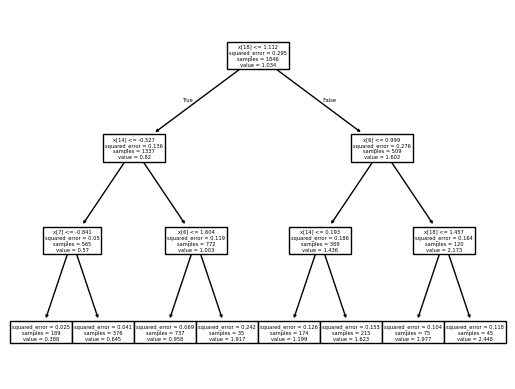

In [110]:
# plt.figure(figsize=(10,20))
plot_tree(model_pipe.named_steps['model'].estimators_[0])
plt.show()

In [111]:
def objective(trial,preprocessor):

    regressor_name = trial.suggest_categorical('regressor',['Rf'])

    if regressor_name == 'Rf':

        n_estimators = trial.suggest_int('model__n_estimators',50,500)
        max_depth = trial.suggest_int('model__max_depth',5,100)
        min_samples_split = trial.suggest_int('model__min_samples_split',2,20)
        min_samples_leaf = trial.suggest_int('model__min_samples_leaf',1,10)
        max_features = trial.suggest_categorical('model__max_features', ['sqrt', 'log2',0.3, 0.5, 0.7, 0.9])
        bootstrap = trial.suggest_categorical('model__bootstrap', [True])

        model_pipe = Pipeline([
            ('target',ce.TargetEncoder(cols=['sector'])),
            ('TargetEncoder',Target_preprocessor),
            ('model',RandomForestRegressor(random_state=0,n_jobs=-1,n_estimators=n_estimators,max_depth=max_depth,
                                              min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf,
                                              max_features=max_features,bootstrap=bootstrap))
        ])

        trial.set_user_attr('model',model_pipe)
    cv_score = cross_val_score(model_pipe,x_train,y_train,cv = KFold(n_splits=5,shuffle=True,random_state=0),
                               scoring='r2')
   
   

    trial.set_user_attr('cv_std',cv_score.std())

    return cv_score.mean()
        

       

In [112]:
study = optuna.create_study(direction='maximize',sampler=optuna.samplers.TPESampler(seed=0))
study.optimize(lambda trial : objective(trial,Target_preprocessor),n_trials=100,n_jobs=1)

[I 2025-08-29 09:55:32,638] A new study created in memory with name: no-name-56db000f-1d8e-4c44-b317-a5ef9567ccc0
[I 2025-08-29 09:55:34,588] Trial 0 finished with value: 0.8491073814451402 and parameters: {'regressor': 'Rf', 'model__n_estimators': 297, 'model__max_depth': 73, 'model__min_samples_split': 13, 'model__min_samples_leaf': 6, 'model__max_features': 0.7, 'model__bootstrap': True}. Best is trial 0 with value: 0.8491073814451402.
[I 2025-08-29 09:55:37,157] Trial 1 finished with value: 0.8346736486657651 and parameters: {'regressor': 'Rf', 'model__n_estimators': 407, 'model__max_depth': 55, 'model__min_samples_split': 12, 'model__min_samples_leaf': 10, 'model__max_features': 0.9, 'model__bootstrap': True}. Best is trial 0 with value: 0.8491073814451402.
[I 2025-08-29 09:55:39,875] Trial 2 finished with value: 0.8449639216474922 and parameters: {'regressor': 'Rf', 'model__n_estimators': 491, 'model__max_depth': 81, 'model__min_samples_split': 10, 'model__min_samples_leaf': 8, '

In [121]:
study.best_value

0.8711587311391673

In [120]:
cv_std = study.best_trial.user_attrs['cv_std']
cv_std

np.float64(0.014341438369554893)

In [116]:
study.best_params

{'regressor': 'Rf',
 'model__n_estimators': 348,
 'model__max_depth': 57,
 'model__min_samples_split': 3,
 'model__min_samples_leaf': 1,
 'model__max_features': 0.5,
 'model__bootstrap': True}

In [117]:
final_model = study.best_trial.user_attrs['model']
final_model.fit(x_train,y_train)

y_pred = final_model.predict(x_test)

y_pred = np.expm1(y_pred)
y_test = np.expm1(y_test)

print(f"Test_MSE:{mean_squared_error(y_test,y_pred)}")
print(f"Test_MAE:{mean_absolute_error(y_test,y_pred)}")
print(f"Test_R2:{r2_score(y_test,y_pred)}")

Test_MSE:1.528103368238784
Test_MAE:0.48884579948770024
Test_R2:0.7950299309576578


In [118]:
fig1 = optuna.visualization.plot_optimization_history(study)
show(fig1)

In [119]:
fig2 = optuna.visualization.plot_param_importances(study)
show(fig2)